In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import cv2
import os
import pathlib
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score
from tensorflow.keras.applications import VGG16

2024-11-28 06:39:24.976255: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class ReadDataset:
    def __init__(self, datasetpath, labels, image_shape):
        self.datasetpath = datasetpath
        self.labels = labels
        self.image_shape = image_shape
    def returListImages(self,):
        self.images = []
        for label in self.labels:
            self.images.append(list(pathlib.Path(os.path.join(self.datasetpath,
                                                              label)).glob('*.*')))
    def readImages(self,):
        self.returListImages()
        self.finalImages = []
        labels = []
        for label in range(len(self.labels)):
            for img in self.images[label]:
                img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = cv2.resize(img , self.image_shape[:2])
                img  = img/255
                img = np.expand_dims(img, axis=-1)  # Add channel dimension to get shape (64, 64, 1)
                self.finalImages.append(img)
                labels.append(label)
        images = np.array(self.finalImages)
        labels = np.array(labels)
        return images, labels
readDatasetObject = ReadDataset('/tf/chest_xray/train',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images, labels = readDatasetObject.readImages()
images.shape, labels.shape

((5216, 64, 64, 1), (5216,))

In [4]:
basemodel = tf.keras.applications.VGG16(weights = None, input_shape = (64, 64, 1),
                                        pooling = 'max', include_top = False)
x = layers.Dropout(0.4)(basemodel.output)
x = layers.Dense(128,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(32,)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha = 0.2)(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)
m = tf.keras.models.Model(inputs = basemodel.input, outputs = x)
m.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00002))
m.summary()

2024-11-28 06:39:52.784677: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [5]:
history = m.fit(images, labels,
                epochs = 80, batch_size = 64,
                validation_split = 0.2,
                callbacks = [tf.keras.callbacks.EarlyStopping(patience = 4, monitor = 'val_loss', mode = 'min',
                                                              restore_best_weights = True)])

Epoch 1/80


2024-11-28 06:39:56.752821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-28 06:39:57.389201: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8844034e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-28 06:39:57.389281: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-11-28 06:39:57.404481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-28 06:39:57.635739: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


66/66 [==============================] - 12s 58ms/step - loss: 0.6331 - val_loss: 0.6899
Epoch 2/80
66/66 [==============================] - 2s 36ms/step - loss: 0.3532 - val_loss: 0.6808
Epoch 3/80
66/66 [==============================] - 2s 35ms/step - loss: 0.2391 - val_loss: 0.6615
Epoch 4/80
66/66 [==============================] - 2s 37ms/step - loss: 0.2094 - val_loss: 0.6238
Epoch 5/80
66/66 [==============================] - 3s 38ms/step - loss: 0.1781 - val_loss: 0.5671
Epoch 6/80
66/66 [==============================] - 2s 38ms/step - loss: 0.1656 - val_loss: 0.4649
Epoch 7/80
66/66 [==============================] - 2s 36ms/step - loss: 0.1624 - val_loss: 0.4374
Epoch 8/80
66/66 [==============================] - 2s 36ms/step - loss: 0.1576 - val_loss: 0.2912
Epoch 9/80
66/66 [==============================] - 2s 36ms/step - loss: 0.1335 - val_loss: 0.2498
Epoch 10/80
66/66 [==============================] - 2s 35ms/step - loss: 0.1247 - val_loss: 0.2764
Epoch 11/80
66/66 [

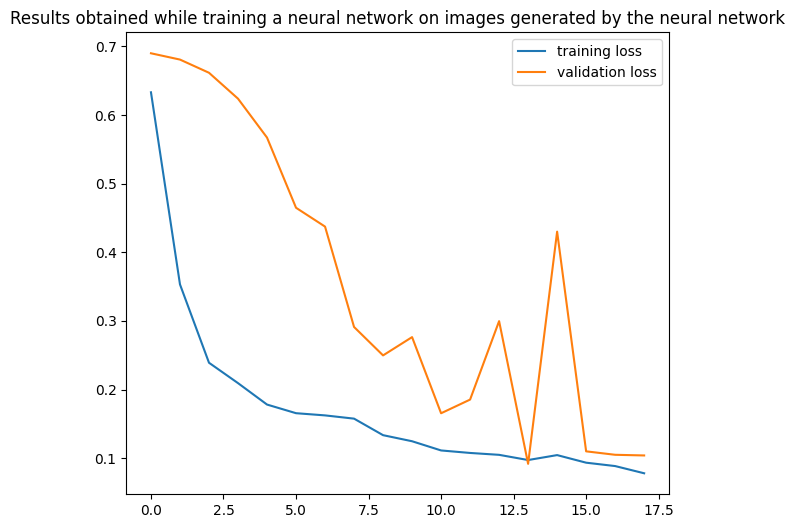

In [6]:
plt.figure(figsize = (7, 6))
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Results obtained while training a neural network on images generated by the neural network')
plt.legend()

In [7]:
readDatasetObject = ReadDataset('/tf/chest_xray/test',
                               ['NORMAL', 'PNEUMONIA'],
                               (64, 64))
images_test, labels_test = readDatasetObject.readImages()

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
def calculate_metrics(model, images, labels):
    loss = model.evaluate(images, labels, verbose=0)  
    y_pred = tf.squeeze(model.predict(images))
    y_pred = y_pred >= 0.5
    y_pred = np.array(y_pred, dtype='int32')
    labels = np.array(labels, dtype='int32')
    acc = accuracy_score(y_pred, labels) * 100
    f1 = f1_score(y_pred, labels) * 100
    recall = recall_score(y_pred, labels) * 100
    precision = precision_score(y_pred, labels) * 100
    cm = confusion_matrix(y_pred, labels)
    cmObject = pd.DataFrame(cm , index = ['NORMAL', 'PNEUMONIA'],
                        columns = ['NORMAL', 'PNEUMONIA'])
    sns.heatmap(cmObject, annot = True, cmap="Blues")
    return {
        'accuracy': acc,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'confusion_matrix': cm
    }


20/20 [==============================] - 0s 6ms/step
1:1 Ratio -> Accuracy: 70.67%, F1 Score: 81.00%, Recall: 68.06%, Precision: 100.00%


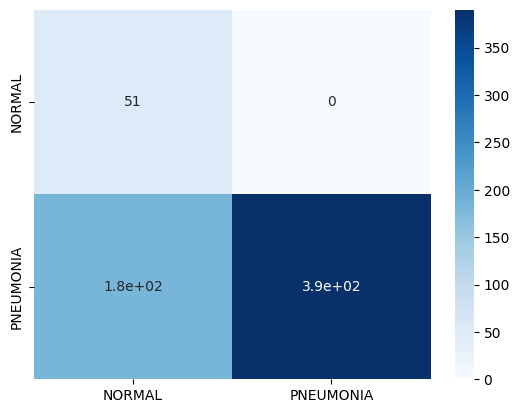

In [9]:
metrics = calculate_metrics(m, images_test, labels_test)
print(f"1:1 Ratio -> Accuracy: {metrics['accuracy']:.2f}%, F1 Score: {metrics['f1_score']:.2f}%, "
      f"Recall: {metrics['recall']:.2f}%, Precision: {metrics['precision']:.2f}%")

In [10]:
print(metrics['confusion_matrix'])

[[ 51   0]
 [183 390]]
